#**Anomaly Detection**

An **Outlier** is nothing but a data point that differs significantly from other data points in the given dataset.

**Anomaly Detection** is the process of finding the outliers in the data, i.e. points that are significantly different from the majority of the other data points.

In [1]:
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz

--2020-10-25 08:57:59--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18115902 (17M) [application/x-gzip]
Saving to: ‘kddcup.data.gz.2’

kddcup.data.gz.2    100%[===================>]  17.28M  20.7MB/s    in 0.8s    

2020-10-25 08:58:00 (20.7 MB/s) - ‘kddcup.data.gz.2’ saved [18115902/18115902]



In [2]:
!pip install pyunpack
!pip install patool

In [3]:
from pyunpack import Archive
Archive('kddcup.data.gz').extractall('/content')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [5]:
cols="""duration,
protocol_type,
service,
flag,
src_bytes,
dst_bytes,
land,
wrong_fragment,
urgent,
hot,
num_failed_logins,
logged_in,
num_compromised,
root_shell,
su_attempted,
num_root,
num_file_creations,
num_shells,
num_access_files,
num_outbound_cmds,
is_host_login,
is_guest_login,
count,
srv_count,
serror_rate,
srv_serror_rate,
rerror_rate,
srv_rerror_rate,
same_srv_rate,
diff_srv_rate,
srv_diff_host_rate,
dst_host_count,
dst_host_srv_count,
dst_host_same_srv_rate,
dst_host_diff_srv_rate,
dst_host_same_src_port_rate,
dst_host_srv_diff_host_rate,
dst_host_serror_rate,
dst_host_srv_serror_rate,
dst_host_rerror_rate,
dst_host_srv_rerror_rate"""

In [6]:
columns=[]
for c in cols.split(','):
    if(c.strip()):
       columns.append(c.strip())

columns.append('target')
#print(columns)
print(len(columns))

42


In [7]:
df = pd.read_csv("kddcup.data.corrected",sep=",",names=columns,index_col=None)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [8]:
df.shape

(4898431, 42)

In [9]:
#filtering df to only have http attacks
df = df[df["service"] == "http"]
df = df.drop("service",axis=1)
columns.remove("service")

In [10]:
df.shape

(623091, 41)

In [11]:
df["target"].value_counts()

normal.       619046
back.           2203
neptune.        1801
portsweep.        16
ipsweep.          13
satan.             7
phf.               4
nmap.              1
Name: target, dtype: int64

In [12]:
for col in df.columns:
  if df[col].dtype == "object":
    encoded = LabelEncoder()
    encoded.fit(df[col])
    df[col] = encoded.transform(df[col])

In [13]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,0,9,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4
1,0,0,9,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,4
2,0,0,9,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,4
3,0,0,9,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,4
4,0,0,9,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,4


In [14]:
df["target"].value_counts()

4    619046
0      2203
2      1801
6        16
1        13
7         7
5         4
3         1
Name: target, dtype: int64

In [15]:
for f in range(0,3):
  df = df.iloc[np.random.permutation(len(df))]


In [16]:
df2 = df[:500000]
labels = df2["target"]
df_validate = df[500000:]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(df2,
                                                    labels,test_size=0.2,random_state=42)

In [18]:
x_val, y_val = df_validate, df_validate["target"]

#**Isolation Forest**

Isolation forest is a machine learning algorithm for anomaly detection.
It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data.

Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

In [19]:
# Machine Learning Model
isolation_forest = IsolationForest(n_estimators=100,
                                   max_samples=256,contamination=0.1,random_state=42)
isolation_forest.fit(x_train)
anomaly_scores = isolation_forest.decision_function(x_val)

In [20]:
anomaly_scores

array([0.09314258, 0.158725  , 0.16208322, ..., 0.0916954 , 0.13098539,
       0.15344307])

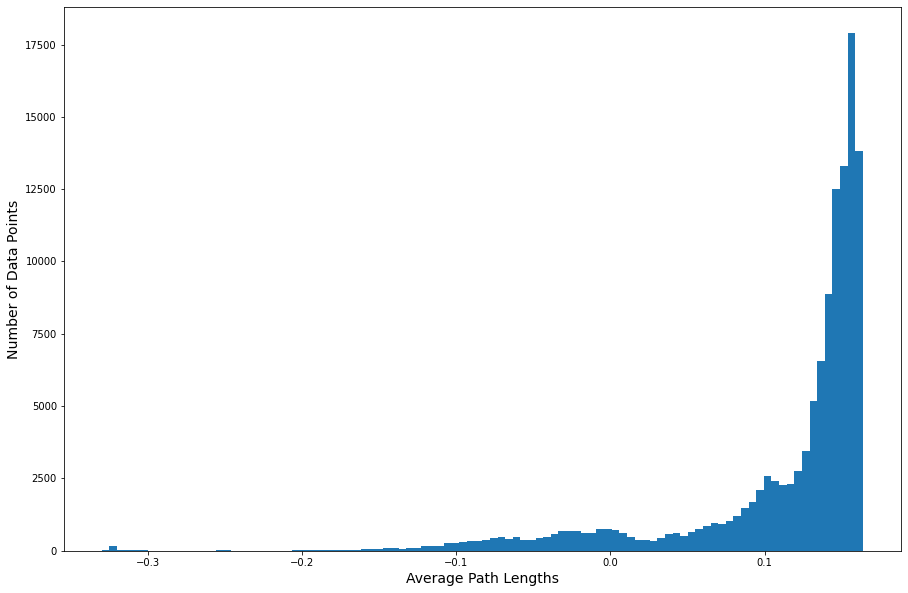

In [21]:
#plot

plt.figure(figsize=(15,10))
plt.hist(anomaly_scores,bins=100)
plt.xlabel("Average Path Lengths",fontsize=14)
plt.ylabel("Number of Data Points",fontsize=14)
plt.show()

A histogram plotting the avg. path lengths for the datapoints.
There is a similar pattern of what appear to be anomalous data to the left of -0.15. Again assume that there are expected outliers and pick any avg. path length less than -0.19 as the cut off anomalies

In [22]:
anomalies = anomaly_scores > -0.19
matches = y_val == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies,matches)

In [23]:
auc

0.91754211761447